Chess Game Result Analysis - 401 Project

Berkay Yıldız - 201104087 

Zeynep Meriç Aşık - 201410026

# TODO
-data need to normalize

-EDA must be increased

-code need to be organised

-corr matrix need to be added

# Importing the Dependencies

In [1]:
#!pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import seaborn as sns

from random import random
import math
from pyspark import SparkContext
import re
from pyspark.sql import functions

In [3]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.conf import SparkConf

from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

In [4]:
from pyspark.ml.linalg import DenseMatrix, Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier as RFC
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

from pyspark.sql.functions import isnan, when, count, col, isnull, concat_ws, split, desc, sum

### func's

In [5]:
def string_to_int(col_name, dataset):
    indexer = StringIndexer(inputCol= col_name , outputCol= col_name+"_ind", stringOrderType="frequencyDesc")
    model = indexer.fit(dataset)
    indexed_dataset = model.transform(dataset)
    #cast double to int and change the dataset
    dataset = indexed_dataset.withColumn(col_name+"_ind", col(col_name+"_ind").cast(IntegerType()))
    grouped_data = dataset.groupBy(col_name).agg(count("*").alias("count"))
    return dict(enumerate(model.labels)),grouped_data, dataset

In [6]:
def printMap_and_showTable(_map,_table):
    print(_map)
    _table.show()

In [7]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [8]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [9]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

c:\users\asus\appdata\local\programs\python\python39\lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [10]:
games = spark.read.format("csv").load("games.csv", header='true', inferSchema='true',  multiline = True)

In [11]:
games.printSchema()

root
 |-- id: string (nullable = true)
 |-- rated: boolean (nullable = true)
 |-- created_at: double (nullable = true)
 |-- last_move_at: double (nullable = true)
 |-- turns: integer (nullable = true)
 |-- victory_status: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- increment_code: string (nullable = true)
 |-- white_id: string (nullable = true)
 |-- white_rating: integer (nullable = true)
 |-- black_id: string (nullable = true)
 |-- black_rating: integer (nullable = true)
 |-- moves: string (nullable = true)
 |-- opening_eco: string (nullable = true)
 |-- opening_name: string (nullable = true)
 |-- opening_ply: integer (nullable = true)



In [12]:
games = games.withColumnRenamed("created_at", "start_time") \
             .withColumnRenamed("last_move_at", "end_time") \
             .withColumnRenamed("increment_code", "time_increment") 

In [13]:
games.limit(5).toPandas()

,id,rated,start_time,end_time,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [14]:
games.select("rated", "winner", "opening_name","time_increment","white_rating","black_rating").show(5, truncate=False)

+-----+------+--------------------------------------+--------------+------------+------------+
|rated|winner|opening_name                          |time_increment|white_rating|black_rating|
+-----+------+--------------------------------------+--------------+------------+------------+
|false|white |Slav Defense: Exchange Variation      |15+2          |1500        |1191        |
|true |black |Nimzowitsch Defense: Kennedy Variation|5+10          |1322        |1261        |
|true |white |King's Pawn Game: Leonardis Variation |5+10          |1496        |1500        |
|true |white |Queen's Pawn Game: Zukertort Variation|20+0          |1439        |1454        |
|true |white |Philidor Defense                      |30+3          |1523        |1469        |
+-----+------+--------------------------------------+--------------+------------+------------+
only showing top 5 rows



In [15]:
games.printSchema()

root
 |-- id: string (nullable = true)
 |-- rated: boolean (nullable = true)
 |-- start_time: double (nullable = true)
 |-- end_time: double (nullable = true)
 |-- turns: integer (nullable = true)
 |-- victory_status: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- time_increment: string (nullable = true)
 |-- white_id: string (nullable = true)
 |-- white_rating: integer (nullable = true)
 |-- black_id: string (nullable = true)
 |-- black_rating: integer (nullable = true)
 |-- moves: string (nullable = true)
 |-- opening_eco: string (nullable = true)
 |-- opening_name: string (nullable = true)
 |-- opening_ply: integer (nullable = true)



In [16]:
games.describe().toPandas()

,summary,id,start_time,end_time,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,count,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058,20058
1,mean,None,1.483616852629092E12,1.4836177223361443E12,60.46599860404826,None,None,None,2.6775729307708335E9,1596.6318675840064,5.294535237863636E9,1588.8319872370128,None,None,None,4.8169807558081565
2,stddev,None,2.850150942100429E10,2.850140058889147E10,33.57058475353722,None,None,None,1.1283509443243038E10,291.253375737019,1.8875165053331074E10,291.03612596033423,None,None,None,2.7971518106301025
3,min,005lW0Xz,1.376771633173E12,1.376771863841E12,1,draw,black,0+12,--jim--,784,-0olo0-,789,Na3 Nf6 b3 e5 e3 Nc6 c4 Be7 d4 exd4 exd4 d5 Nc...,A00,Alekhine Defense,1
4,max,zzcDhaYF,1.50449314379E12,1.504493827262E12,349,resign,white,90+8,zzzimon,2700,zztopillo,2723,h4 e6 g3 d5 Bh3 c5 d3 Nc6 c3 Qb6 a3 Nh6 Bxh6 g...,E98,Zukertort Opening: Wade Defense,28


In [17]:
missing = games.select([count(when(isnull(c), c)).alias(c) for c in games.columns]).show()

+---+-----+----------+--------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+
| id|rated|start_time|end_time|turns|victory_status|winner|time_increment|white_id|white_rating|black_id|black_rating|moves|opening_eco|opening_name|opening_ply|
+---+-----+----------+--------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+
|  0|    0|         0|       0|    0|             0|     0|             0|       0|           0|       0|           0|    0|          0|           0|          0|
+---+-----+----------+--------+-----+--------------+------+--------------+--------+------------+--------+------------+-----+-----------+------------+-----------+



No missing (null) values.

# EDA

<AxesSubplot:xlabel='victory_status'>

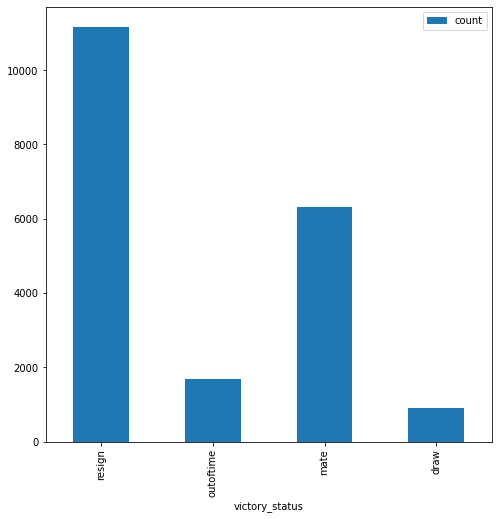

In [18]:
# group by victory status and see the distribution
result = games.groupBy("victory_status").count().sort("victory_status", ascending=False)
result.toPandas().plot.bar(x='victory_status',figsize=(8, 8))

<AxesSubplot:xlabel='winner'>

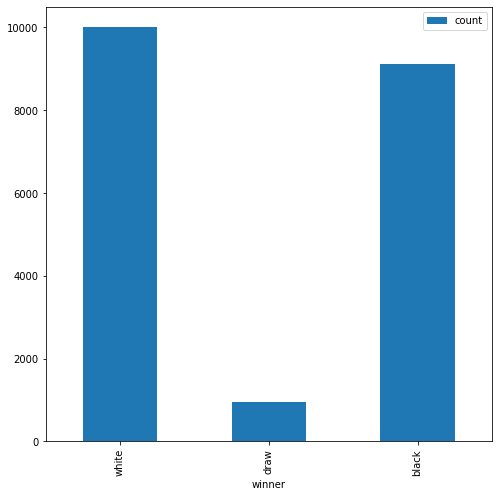

In [19]:
# group by winner and see the distribution
result = games.groupBy("winner").count().sort("winner", ascending=False)
result.toPandas().plot.bar(x='winner',figsize=(8, 8))

In [20]:
grouped_df = games.groupBy('opening_name', 'winner').agg(count('winner').alias('wins'))
open_ = grouped_df.orderBy(desc('wins'))

black_wins = open_[open_['winner'] == 'black']
white_wins = open_[open_['winner'] == 'white']

Text(0, 0.5, 'Number of Wins')

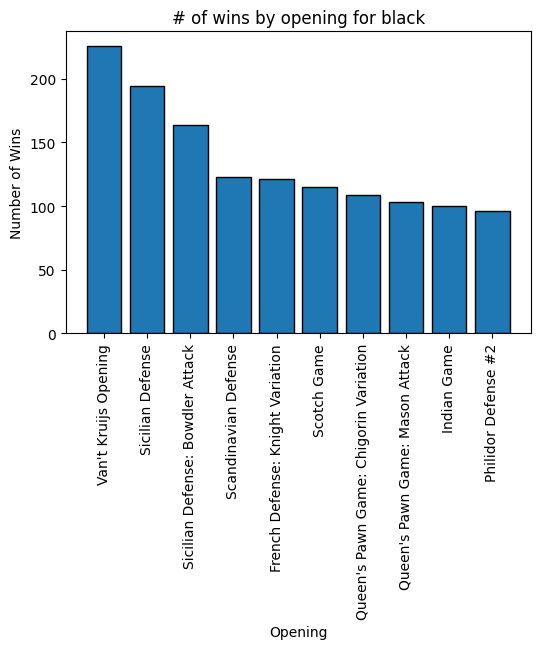

In [76]:
b = black_wins.limit(10)
x = b.toPandas().opening_name
y = b.toPandas().wins
plt.figure(dpi=100)
plt.bar(x, height=y, edgecolor='black')
plt.xticks(rotation='vertical')
plt.title('Most # of wins by opening for black player')
plt.xlabel('Opening')
plt.ylabel('Number of Wins')

Text(0, 0.5, 'Number of Wins')

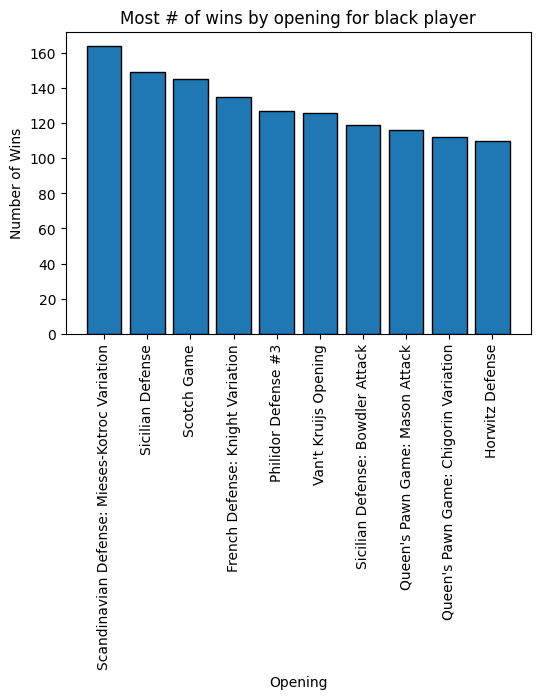

In [77]:
w = white_wins.limit(10)
x = w.toPandas().opening_name
y = w.toPandas().wins
plt.figure(dpi=100)
plt.bar(x, height=y, edgecolor='black')
plt.xticks(rotation='vertical')
plt.title('Most # of wins by opening for black player')
plt.xlabel('Opening')
plt.ylabel('Number of Wins')

These are the top 10 openings which have the most wins for black and white player.

In [78]:
mask = ['white_id', 'white_rating']
white_player_df = df[mask]
white_player_df.columns = ['player_id', 'player_rating']
mask = ['black_id', 'black_rating']
black_player_df = df[mask]
black_player_df = black_player_df[mask]
black_player_df.columns = ['player_id', 'player_rating']
player_df = pd.concat([white_player_df, black_player_df])

+--------+-----+----------+----------+-----+--------------+------+--------------+------------------+------------+------------------+------------+--------------------+-----------+--------------------+-----------+
|      id|rated|start_time|  end_time|turns|victory_status|winner|time_increment|          white_id|white_rating|          black_id|black_rating|               moves|opening_eco|        opening_name|opening_ply|
+--------+-----+----------+----------+-----+--------------+------+--------------+------------------+------------+------------------+------------+--------------------+-----------+--------------------+-----------+
|TZJHLljE|false|1.50421E12|1.50421E12|   13|     outoftime| white|          15+2|          bourgris|        1500|              a-00|        1191|d4 d5 c4 c6 cxd5 ...|        D10|Slav Defense: Exc...|          5|
|l1NXvwaE| true|1.50413E12|1.50413E12|   16|        resign| black|          5+10|              a-00|        1322|         skinnerua|        1261|d4 Nc6 

## Preprocessing and Analyzing the Data

In [104]:
#controlling duplicated values
window_spec = Window.partitionBy("id")
games_with_count = games.withColumn("count", F.count("id").over(window_spec))
duplicate_rows = games_with_count.filter("count > 1")
duplicate_rows = duplicate_rows.orderBy("id")
#to see duplicated values
# duplicate_rows.toPandas()
sum_of_duplicated_values = duplicate_rows.select(F.sum("count")).collect()[0][0]
print("Sum of all duplicated values:", sum_of_duplicated_values)

Sum of all duplicated values: 3968


In [105]:
games = games.dropDuplicates(subset=["id"])

In [106]:
games.describe().toPandas()

,summary,id,start_time,end_time,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,count,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113,19113
1,mean,None,1.4834131013193103E12,1.4834139747733328E12,60.513838748495786,None,None,None,2.73448511712766E9,1597.300005232041,6.019286096111111E9,1590.045518756867,None,None,None,4.815779835713912
2,stddev,None,2.833975096426027E10,2.8339639419694542E10,33.48826396268022,None,None,None,1.1398530926117226E10,290.0227398102658,2.0835821566559532E10,290.4416944907074,None,None,None,2.7982829080050116
3,min,005lW0Xz,1.376771633173E12,1.376771863841E12,1,draw,black,0+12,--jim--,784,-0olo0-,789,Na3 Nf6 b3 e5 e3 Nc6 c4 Be7 d4 exd4 exd4 d5 Nc...,A00,Alekhine Defense,1
4,max,zzcDhaYF,1.50449314379E12,1.504493827262E12,349,resign,white,90+8,zzzimon,2700,zztopillo,2723,h4 e6 g3 d5 Bh3 c5 d3 Nc6 c3 Qb6 a3 Nh6 Bxh6 g...,E98,Zukertort Opening: Wade Defense,28


In [107]:
dataset = games.select("*")

In [108]:
dataset2 = games.select("*")

## --------------------------Rate values to INT--------------------------

In [109]:
#converting to str
dataset = dataset.withColumn("rated", when(col("rated").cast("string") == "true", "true").otherwise("false"))

In [110]:
rate_map,rate_table,dataset = string_to_int("rated",dataset)

In [111]:
printMap_and_showTable(rate_map,rate_table)

{0: 'true', 1: 'false'}
+-----+-----+
|rated|count|
+-----+-----+
|false| 3646|
| true|15467|
+-----+-----+



## --------------------------Victory values to INT--------------------------

In [112]:
vic_map,vic_table,dataset = string_to_int("victory_status",dataset)

In [113]:
printMap_and_showTable(vic_map,vic_table)

{0: 'resign', 1: 'mate', 2: 'outoftime', 3: 'draw'}
+--------------+-----+
|victory_status|count|
+--------------+-----+
|        resign|10695|
|     outoftime| 1598|
|          mate| 5974|
|          draw|  846|
+--------------+-----+



## --------------------------Winner values to INT--------------------------

In [114]:
win_map,win_table,dataset = string_to_int("winner",dataset)

In [115]:
printMap_and_showTable(win_map,win_table)

{0: 'white', 1: 'black', 2: 'draw'}
+------+-----+
|winner|count|
+------+-----+
| white| 9545|
| black| 8680|
|  draw|  888|
+------+-----+



White appears to win approximately 50.0 % of the games  
while Black wins 45.0 % of the games  
and 5.0 % of the games are a draw

## --------------------------Opening Name values to INT--------------------------

In [52]:
openName_map,openName_table,dataset = string_to_int("opening_name",dataset)

In [53]:
printMap_and_showTable(openName_map,openName_table)

{0: 'Sicilian Defense', 1: "Van't Kruijs Opening", 2: 'Sicilian Defense: Bowdler Attack', 3: 'French Defense: Knight Variation', 4: 'Scotch Game', 5: 'Scandinavian Defense: Mieses-Kotroc Variation', 6: "Queen's Pawn Game: Mason Attack", 7: "Queen's Pawn Game: Chigorin Variation", 8: 'Scandinavian Defense', 9: 'Horwitz Defense', 10: 'Caro-Kann Defense', 11: 'Philidor Defense #3', 12: 'Philidor Defense #2', 13: 'Indian Game', 14: 'Modern Defense', 15: 'Italian Game: Anti-Fried Liver Defense', 16: "King's Pawn Game: Wayward Queen Attack", 17: 'Four Knights Game: Italian Variation', 18: 'Owen Defense', 19: 'Sicilian Defense: Old Sicilian', 20: "King's Pawn Game: Leonardis Variation", 21: "Queen's Pawn Game", 22: 'Philidor Defense', 23: 'Ruy Lopez: Steinitz Defense', 24: "Queen's Pawn", 25: "Queen's Gambit Refused: Marshall Defense", 26: "Bishop's Opening", 27: 'French Defense: Normal Variation', 28: 'Hungarian Opening', 29: "Queen's Gambit Declined", 30: "Queen's Pawn Game: Zukertort Varia

+--------------------+-----+
|        opening_name|count|
+--------------------+-----+
|Alekhine Defense:...|    3|
|King's Indian Att...|    4|
|Sicilian Defense:...|    2|
|Caro-Kann Defense...|    1|
|Owen Defense: Smi...|    2|
|Sicilian Defense:...|   48|
|Sicilian Defense:...|    1|
|Queen's Gambit Ac...|   11|
|French Defense: C...|    8|
|French Defense: S...|   10|
|French Defense: W...|    1|
|King's Pawn Game:...|   78|
|  St. George Defense|   43|
|Nimzowitsch Defen...|   24|
|Pirc Defense: Aus...|    6|
|Scotch Game: Mala...|    6|
|Ruy Lopez: Berlin...|    5|
|Nimzo-Larsen Atta...|    6|
|French Defense: F...|    1|
|Sicilian Defense:...|    1|
+--------------------+-----+
only showing top 20 rows



## --------------------------Opening eco values to INT--------------------------

In [54]:
openEco_map,openEco_table,dataset = string_to_int("opening_eco",dataset)

In [55]:
printMap_and_showTable(openEco_map,openEco_table)

{0: 'A00', 1: 'C00', 2: 'D00', 3: 'B01', 4: 'C41', 5: 'C20', 6: 'A40', 7: 'B00', 8: 'B20', 9: 'C50', 10: 'C40', 11: 'D02', 12: 'C44', 13: 'C42', 14: 'B07', 15: 'C55', 16: 'C45', 17: 'C02', 18: 'A04', 19: 'C46', 20: 'A45', 21: 'B21', 22: 'B50', 23: 'B30', 24: 'D20', 25: 'B10', 26: 'B06', 27: 'C21', 28: 'D06', 29: 'A01', 30: 'B12', 31: 'C01', 32: 'B02', 33: 'C23', 34: 'D30', 35: 'C62', 36: 'A10', 37: 'B40', 38: 'B32', 39: 'C57', 40: 'A06', 41: 'C24', 42: 'D10', 43: 'C65', 44: 'B23', 45: 'C60', 46: 'B90', 47: 'A20', 48: 'B22', 49: 'C68', 50: 'C30', 51: 'D01', 52: 'C53', 53: 'B13', 54: 'A46', 55: 'C48', 56: 'E20', 57: 'A03', 58: 'A43', 59: 'D31', 60: 'A02', 61: 'B54', 62: 'C22', 63: 'A41', 64: 'C34', 65: 'D35', 66: 'C70', 67: 'B27', 68: 'C26', 69: 'A21', 70: 'E61', 71: 'A15', 72: 'C10', 73: 'A22', 74: 'A80', 75: 'C64', 76: 'C47', 77: 'A13', 78: 'B25', 79: 'B33', 80: 'E00', 81: 'D07', 82: 'D15', 83: 'B08', 84: 'C77', 85: 'D04', 86: 'D11', 87: 'C11', 88: 'C54', 89: 'C61', 90: 'A30', 91: 'B34

## -------------------------- Time Inc values to INT--------------------------

In [56]:
timeInc_map,timeInc_table,dataset = string_to_int("time_increment",dataset)

In [57]:
printMap_and_showTable(timeInc_map,timeInc_table)

{0: '10+0', 1: '15+0', 2: '15+15', 3: '5+5', 4: '5+8', 5: '8+0', 6: '10+5', 7: '15+10', 8: '20+0', 9: '30+0', 10: '10+10', 11: '15+5', 12: '7+2', 13: '10+2', 14: '30+30', 15: '5+10', 16: '10+3', 17: '25+0', 18: '10+8', 19: '20+10', 20: '15+2', 21: '10+15', 22: '9+0', 23: '45+45', 24: '20+5', 25: '8+8', 26: '180+0', 27: '15+8', 28: '30+10', 29: '10+1', 30: '8+5', 31: '12+0', 32: '20+15', 33: '7+5', 34: '180+180', 35: '60+0', 36: '15+3', 37: '7+7', 38: '7+9', 39: '20+20', 40: '20+3', 41: '6+5', 42: '15+1', 43: '7+3', 44: '8+2', 45: '9+5', 46: '12+10', 47: '11+0', 48: '5+7', 49: '30+5', 50: '5+6', 51: '7+4', 52: '15+14', 53: '7+8', 54: '5+15', 55: '4+6', 56: '7+10', 57: '45+0', 58: '7+15', 59: '9+8', 60: '3+8', 61: '10+4', 62: '2+10', 63: '25+3', 64: '8+10', 65: '10+6', 66: '25+5', 67: '8+3', 68: '25+25', 69: '6+8', 70: '14+0', 71: '20+60', 72: '20+8', 73: '6+4', 74: '6+6', 75: '10+30', 76: '16+0', 77: '20+30', 78: '12+5', 79: '15+60', 80: '5+60', 81: '6+3', 82: '12+12', 83: '6+10', 84: '

## --------------------------Other--------------------------

In [58]:
dataset = dataset.withColumn("game_duration", (col("end_time") - col("start_time")).cast("double"))

In [59]:
columns_to_drop = ["id", "rated", "victory_status", "winner", "start_time", "end_time", "white_id", "black_id", "moves","opening_name","opening_eco","time_increment"]
dataset = dataset.drop(*columns_to_drop)

"id" column is dropped since it is does not provide information for analysis.
Our goal is to analyze the moves and its results, not the specific player's chess skills. So "white_id" and "black_id" columns are dropped, but their ratings remain.  
"created_at" and "last_move_at" columns are dropped and the difference was added to new column "game_duration".  
Other columns are dropped because they are stored in one hot form in different columns (_ind).  
Original dataset is stored in "games" dataframe. Preprocessed data will be used to perform analysis and prediction.  


In [60]:
dataset.limit(5).toPandas()

,turns,white_rating,black_rating,opening_ply,rated_ind,victory_status_ind,winner_ind,opening_name_ind,opening_eco_ind,time_increment_ind,game_duration
0,37,1500,1479,10,1,0,0,237,135,6,371839.0
1,36,1890,1838,4,0,0,1,29,34,5,287937.0
2,54,1207,1588,7,0,1,1,444,17,24,0.0
3,114,1689,2201,3,0,0,1,2,8,5,0.0
4,47,1568,1561,4,0,1,0,72,10,19,770082.0


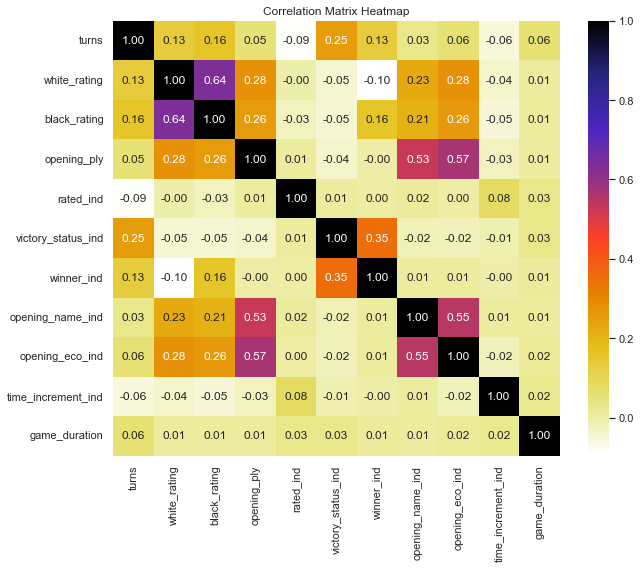

In [84]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(inputCols=dataset.columns, outputCol="features")
assembled_df = assembler.transform(dataset)

correlation_matrix = Correlation.corr(assembled_df, "features", "pearson")

correlation_matrix_pd = correlation_matrix.select("pearson(features)").collect()[0][0]
correlation_matrix_np = np.array(correlation_matrix_pd.toArray())

sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_np, annot=True, fmt=".2f", cmap=plt.cm.CMRmap_r, xticklabels=dataset.columns, yticklabels=dataset.columns)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [46]:
#PCA ##########change code
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="turns", outputCol="scaledFeatures", withMean=True, withStd=True)
scalerModel = scaler.fit(games)
data = scalerModel.transform(games)
data

IllegalArgumentException: requirement failed: Column turns must be of type class org.apache.spark.ml.linalg.VectorUDT:struct<type:tinyint,size:int,indices:array<int>,values:array<double>> but was actually class org.apache.spark.sql.types.IntegerType$:int.

In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pcaModel = pca.fit(data)
pcaData = pcaModel.transform(data)

In [ ]:
explainedVariance = pcaModel.explainedVariance
print(explainedVariance)

## ML